# Дамашнее задание №3
Фадеичев Даниил 

Требуется оценить успеваемость студентов по данным из Kaggle. 

In [3]:
import vaex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import vaex.agg as agg

Так как объем данных одной из таблиц превышвет 100 000 000 строк, будет тяжело проводить анализ используя файл csv и pandas на обычном пк. Для ускорения и упрощения процесса следует воспользователься библиотекой vaex и форматом файла hdf5. Поэтому первым шагом будет перевести все csv файлы в формат hdf5:

In [ ]:
questions = vaex.from_csv(r"questions.csv",convert =True, chunk_size = 5_000_000, sep = ',')
lectures = vaex.from_csv(r"lectures.csv",convert =True, chunk_size = 5_000_000, sep = ',')

# Поскольку формат hdf5 не поддерживает тип object:
train = vaex.from_csv('train.csv', convert=False, copy_index=False)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')
train.export_hdf5('train.csv.hdf5')

Теперь можно прочитать эти файлы, глобально это не нужно поскольку они уже в программе, но для сравнения скорости открытия с csv это можно сделать:

In [5]:
lectures = vaex.open('lectures.csv.hdf5')
questions = vaex.open('questions.csv.hdf5')
train = vaex.open('train.csv.hdf5')

In [6]:
lectures.head()

#,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
5,335,114,2,concept
6,484,179,5,concept
7,641,134,6,solving question
8,761,93,1,concept
9,814,80,5,solving question


In [7]:
train.head()

#,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,nan,True
1,1,56943,115,5716,0,2,2,1,37000,False
2,2,118363,115,128,0,0,0,1,55000,False
3,3,131167,115,7860,0,3,0,1,19000,False
4,4,137965,115,7922,0,4,1,1,11000,False
5,5,157063,115,156,0,5,2,1,5000,False
6,6,176092,115,51,0,6,0,1,17000,False
7,7,194190,115,50,0,7,3,1,17000,False
8,8,212463,115,7896,0,8,2,1,16000,False
9,9,230983,115,7863,0,9,0,1,16000,False


In [8]:
questions.head()

#,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
5,5,5,2,1,131 149 162 81
6,6,6,2,1,10 94 162 92
7,7,7,0,1,61 110 162 29
8,8,8,3,1,131 13 162 92
9,9,9,3,1,10 164 81


Все данные прочитались и записались в переменные, далее следует сгрупировать некоторые данные для анализа:

In [9]:
# Фильтрация только лекций
train_lectures = train[train.content_type_id == 1]

# Переименование колонок для объединения
train_lectures.rename('content_id', 'lecture_id')

# Объединение с lectures
train_lectures = train_lectures.join(lectures, on='lecture_id', rsuffix='_l', how='left')

In [10]:
# Фильтрация только вопросов
train_questions = train[train.content_type_id == 0]

# Переименование колонок для объединения
train_questions.rename('content_id', 'question_id')

# Объединение с questions
train_questions = train_questions.join(questions, on='question_id', rsuffix='_q', how='left')

In [11]:
train_questions.head()

#,row_id,timestamp,user_id,question_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id_q,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,nan,True,5692,5692,3,5,151
1,1,56943,115,5716,0,2,2,1,37000,False,5716,5716,2,5,168
2,2,118363,115,128,0,0,0,1,55000,False,128,128,0,1,131 149 92
3,3,131167,115,7860,0,3,0,1,19000,False,7860,7860,0,1,131 104 81
4,4,137965,115,7922,0,4,1,1,11000,False,7922,7922,1,1,131 149 92
5,5,157063,115,156,0,5,2,1,5000,False,156,156,2,1,131 101 162 38
6,6,176092,115,51,0,6,0,1,17000,False,51,51,0,1,131 187 81
7,7,194190,115,50,0,7,3,1,17000,False,50,50,3,1,131 101 38
8,8,212463,115,7896,0,8,2,1,16000,False,7896,7896,2,1,131 104 162 81
9,9,230983,115,7863,0,9,0,1,16000,False,7863,7863,0,1,131 68 92


In [12]:
train_lectures.head()

#,row_id,timestamp,user_id,lecture_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id_l,tag,part,type_of
0,89,653762,2746,6808,1,14,-1,-1,nan,False,6808,129,2,intention
1,117,10183847,5382,16736,1,21,-1,-1,nan,False,16736,40,1,concept
2,212,1424348597,5382,30207,1,104,-1,-1,nan,False,30207,43,5,concept
3,216,1425557777,5382,18545,1,121,-1,-1,nan,False,18545,58,5,concept
4,295,405813029,8623,10540,1,59,-1,-1,nan,False,10540,99,1,concept
5,302,406265768,8623,25843,1,66,-1,-1,nan,False,25843,164,1,concept
6,323,577424049,8623,29544,1,87,-1,-1,nan,False,29544,30,2,concept
7,409,3083871588,12741,20307,1,33,-1,-1,nan,False,20307,170,6,concept
8,441,3263276452,12741,10688,1,53,-1,-1,nan,False,10688,39,7,concept
9,486,3268387671,12741,10217,1,66,-1,-1,nan,False,10217,19,7,concept


Все готово для анализа характеристик успеваемости студентов. Первая характеристика это зависимость между процентным соотношением верных ответов студента с количеством прочитанных лекций:

In [13]:
# Количество лекций на пользователя
lectures_per_user = train_lectures.groupby('user_id', agg={'num_lectures': 'count'})

# Процент правильных ответов на пользователя
correct_answers = train_questions[train_questions.answered_correctly == 1].groupby('user_id', agg={'correct_count': 'count'})
total_questions = train_questions.groupby('user_id', agg={'total_questions': 'count'})
percentage_correct = correct_answers.join(total_questions, on='user_id', how='inner')
percentage_correct = percentage_correct.copy()
percentage_correct['perc_correct'] = percentage_correct['correct_count'] / percentage_correct['total_questions'] * 100

# Объединение признаков
user_stats = lectures_per_user.join(percentage_correct, on='user_id', how='inner')

Для наглядности результаты следует изобразить на графике:

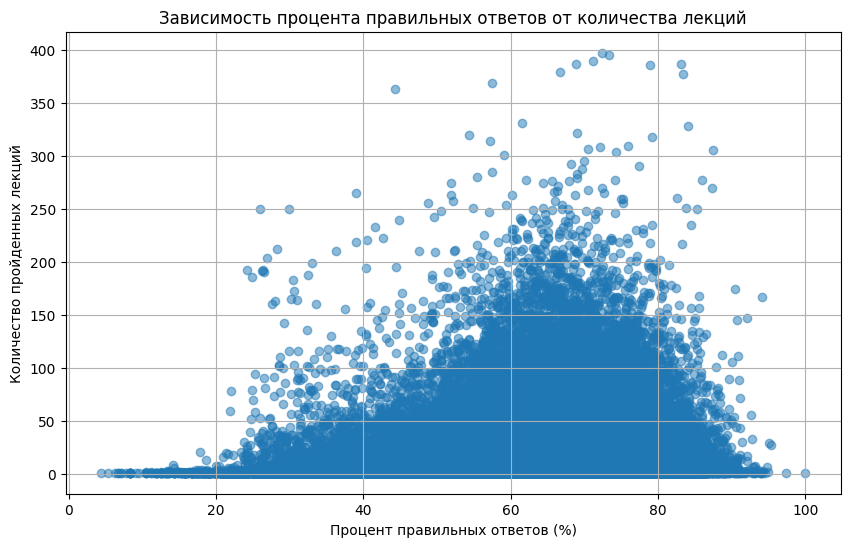

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(user_stats['perc_correct'].evaluate(), user_stats['num_lectures'].evaluate(), alpha=0.5)
plt.ylabel('Количество пройденных лекций')
plt.xlabel('Процент правильных ответов (%)')
plt.title('Зависимость процента правильных ответов от количества лекций')
plt.grid(True)
plt.show()

По графику можно заметить закономерности, но для более точного анализа следует найти линию тренда и разделить студентов на кластеры. Это поможет интерпретировать эти результаты лучше:

In [ ]:
# Преобразование данных в pandas DataFrame
user_stats_pd = user_stats.to_pandas_df()

# Извлечение признаков для кластеризации и тренда
X = user_stats_pd[['perc_correct', 'num_lectures']].dropna()

# Кластеризация KMeans на 3 кластера
kmeans = KMeans(n_clusters=3)
X['cluster'] = kmeans.fit_predict(X)

# Линейная регрессия для трендовой линии
lin_reg = LinearRegression()
lin_reg.fit(X[['perc_correct']], X['num_lectures'])
trend_line = lin_reg.predict(X[['perc_correct']])

# Визуализация данных с кластерами и линией тренда
plt.figure(figsize=(10, 6))

# Scatter plot с учетом кластеров
plt.scatter(X['perc_correct'], X['num_lectures'], c=X['cluster'], cmap='viridis', alpha=0.5, label="Студенты")

# Линия тренда
plt.plot(X['perc_correct'], trend_line, color='red', label="Линия тренда")

# Настройки графика
plt.xlabel('Процент правильных ответов (%)')
plt.ylabel('Количество пройденных лекций')
plt.title('Зависимость процента правильных ответов от количества лекций с кластеризацией и линией тренда')
plt.grid(True)
plt.legend()

# Отображение графика
plt.show()

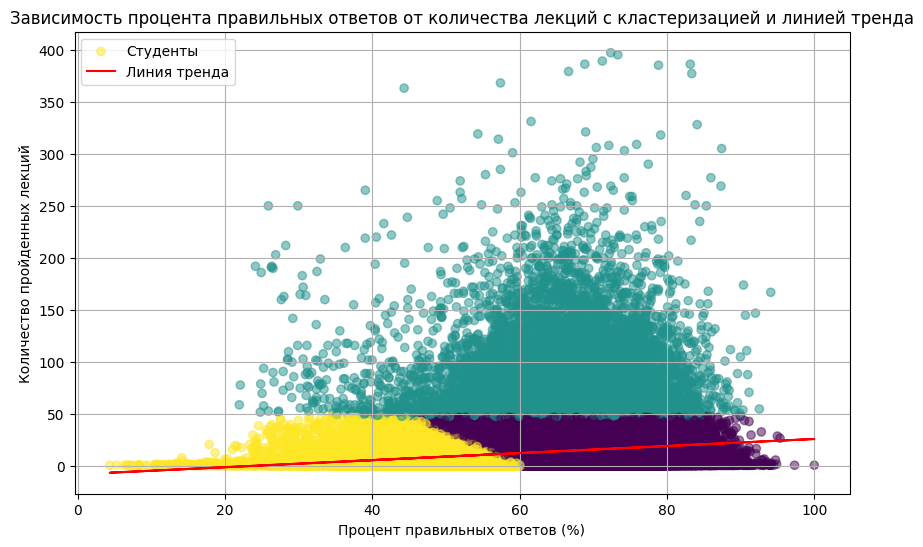

Желтый кластер:

    Это группа студентов с очень низким количеством пройденных лекций (от 0 до 50 лекций) и процентом правильных ответов, который чаще всего находится в диапазоне от 0% до 40%. Эти студенты могут либо только начать обучение, либо они испытывают трудности с усвоением материала.

Фиолетовый кластер :

    Студенты из фиолетового кластера прошли до 50 лекций и показывают результаты лучше, чем студенты из желтого кластера, с процентом правильных ответов в диапазоне 40-100%. Несмотря на то, что они прошли мало лекций, их успехи выше, чем у желтого кластера. Это может означать, что они либо учатся быстрее, либо имеют более высокие стартовые знания.

Зеленый кластер:

    Этот кластер включает студентов, которые прошли большее количество лекций (50–350+) и показывают самые разные результаты, от низких до высоких. Студенты из этого кластера явно потратили больше времени на обучение и прошли больше лекций, но результаты в процентах правильных ответов сильно варьируются. Это может свидетельствовать о том, что для многих студентов количество лекций не всегда коррелирует с качеством усвоения материала.

Линия тренда (красная линия):

    Линия тренда показывает положительную, но слабую зависимость между количеством пройденных лекций и процентом правильных ответов. Она слегка поднимается вверх, что указывает на то, что большее количество лекций может немного увеличить успеваемость, но рост незначительный.

Выводы:

    Количество пройденных лекций не всегда гарантирует успех: Студенты, которые прошли большее количество лекций (зеленый кластер), не всегда показывают более высокие результаты. Это подчеркивает важность качественного усвоения материала, а не только его объема.

    Нужно адаптировать стратегию обучения для различных групп: Желтый кластер студентов может нуждаться в дополнительной помощи или разборе базовых тем, в то время как фиолетовый кластер может быть уже готов к более сложным заданиям и материалам.

    Линия тренда показывает ограниченное влияние количества лекций на успех: Увеличение числа лекций связано с небольшим ростом процента правильных ответов, но этот рост невелик. Это может быть связано с тем, что ключевую роль играют другие факторы, такие как качество материала, мотивация и способности студентов. Очень вероятно что для повышения успеваемости следует переработать лекционный материал, поскольку он очень слабо влеяет на успеваемость.

Вторая характеристика это зависимость между процентным соотношением верных ответов студента и средним временем затраченным на ответ:

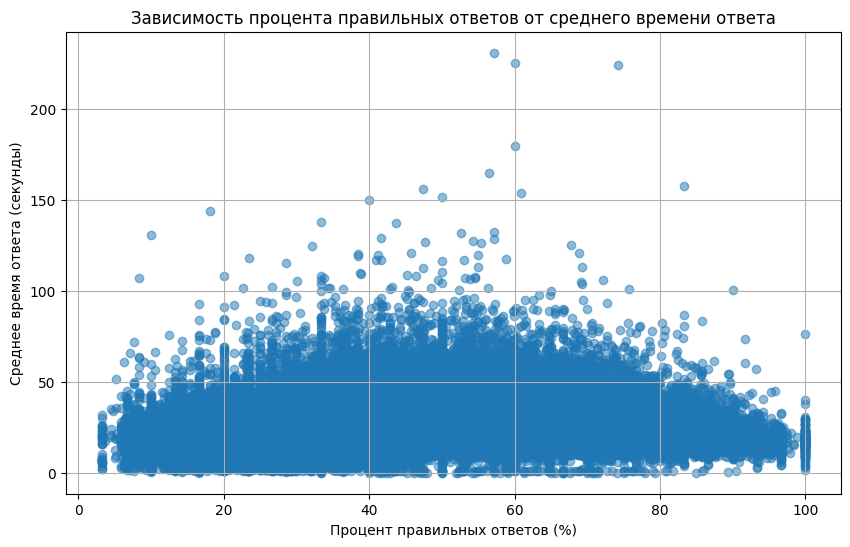

In [16]:
# Правильный синтаксис агрегации: указываем столбец для вычисления среднего
avg_time = train_questions.groupby('user_id', agg={'avg_response_time': agg.mean('prior_question_elapsed_time')})

# Объединение с процентом правильных ответов
user_stats_time = avg_time.join(percentage_correct, on='user_id', how='inner')

avg_response_time = user_stats_time['avg_response_time'].evaluate() / 1000  # перевод времени в секунды
perc_correct = user_stats_time['perc_correct'].evaluate()

# Построение scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(perc_correct, avg_response_time, alpha=0.5)
plt.ylabel('Среднее время ответа (секунды)')
plt.xlabel('Процент правильных ответов (%)')
plt.title('Зависимость процента правильных ответов от среднего времени ответа')
plt.grid(True)
plt.show()

Для более информотивного анализа следует поделить студентов на группы по времени ответа и успеваемости:

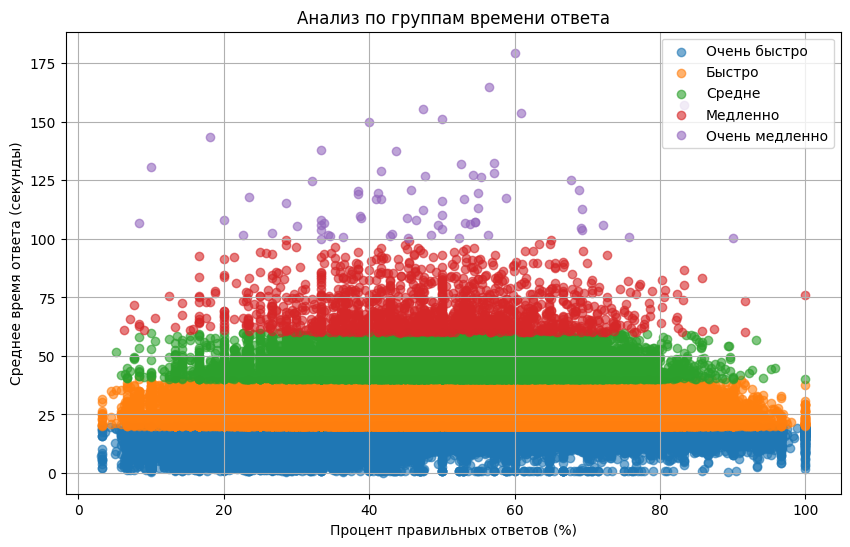

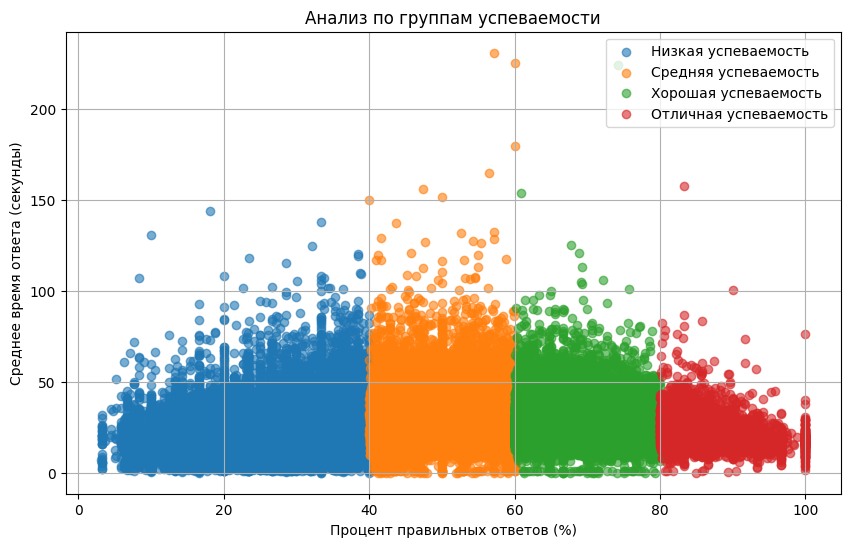

In [17]:
# Разделение студентов на группы по времени ответа
time_bins = [0, 20, 40, 60, 100, 200]
time_labels = ['Очень быстро', 'Быстро', 'Средне', 'Медленно', 'Очень медленно']
user_stats_time_pd = pd.DataFrame({
    'avg_response_time': avg_response_time,
    'perc_correct': perc_correct
})
user_stats_time_pd['time_group'] = pd.cut(user_stats_time_pd['avg_response_time'], bins=time_bins, labels=time_labels)

# Разделение студентов на группы по проценту правильных ответов
correct_bins = [0, 40, 60, 80, 100]
correct_labels = ['Низкая успеваемость', 'Средняя успеваемость', 'Хорошая успеваемость', 'Отличная успеваемость']
user_stats_time_pd['correct_group'] = pd.cut(user_stats_time_pd['perc_correct'], bins=correct_bins, labels=correct_labels)

# Анализ по группам времени ответа
time_group_analysis = user_stats_time_pd.groupby('time_group', observed=False).agg({'avg_response_time': 'mean', 'perc_correct': ['mean', 'count']})

# Анализ по группам процента правильных ответов
correct_group_analysis = user_stats_time_pd.groupby('correct_group', observed=False).agg({'avg_response_time': 'mean', 'perc_correct': ['mean', 'count']})

# Визуализация по группам времени ответа
plt.figure(figsize=(10, 6))
for group in time_labels:
    group_data = user_stats_time_pd[user_stats_time_pd['time_group'] == group]
    plt.scatter(group_data['perc_correct'], group_data['avg_response_time'], label=group, alpha=0.6)

plt.ylabel('Среднее время ответа (секунды)')
plt.xlabel('Процент правильных ответов (%)')
plt.title('Анализ по группам времени ответа')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Визуализация по группам успеваемости
plt.figure(figsize=(10, 6))
for group in correct_labels:
    group_data = user_stats_time_pd[user_stats_time_pd['correct_group'] == group]
    plt.scatter(group_data['perc_correct'], group_data['avg_response_time'], label=group, alpha=0.6)

plt.ylabel('Среднее время ответа (секунды)')
plt.xlabel('Процент правильных ответов (%)')
plt.title('Анализ по группам успеваемости')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

    Разные группы студентов показывают разнообразные результаты по успеваемости в зависимости от времени ответа. Студенты, которые отвечают очень быстро или очень медленно, могут испытывать сложности с правильными ответами. Это указывает на то, что важно не только скорость, но и качество усвоения материала. Средне отвечающие студенты демонстрируют более стабильные результаты, что может означать, что среднее время ответа лучше коррелирует с успеваемостью.

    Студенты с высокой успеваемостью (красная и зеленая группы) чаще отвечают быстрее, что может быть связано с уверенностью в знаниях и лучшим пониманием материала. Студенты с низкой успеваемостью могут тратить много времени на ответы, но это не всегда ведет к улучшению результатов. Важно не только время ответа, но и понимание материала. Студенты с низкой успеваемостью нуждаются в дополнительных ресурсах и поддержке, чтобы улучшить свои результаты.

Вывод:

    Оба графика показывают, что время ответа является важным фактором, но само по себе не является гарантией успеха. Студенты с лучшими результатами часто отвечают быстрее, но не обязательно "очень быстро". Студенты с низкими результатами могут тратить как много, так и мало времени на ответы, но при этом сталкиваться с трудностями.

Третья характеритика это зависимость процента правильных ответов и наличия объяснения решения:

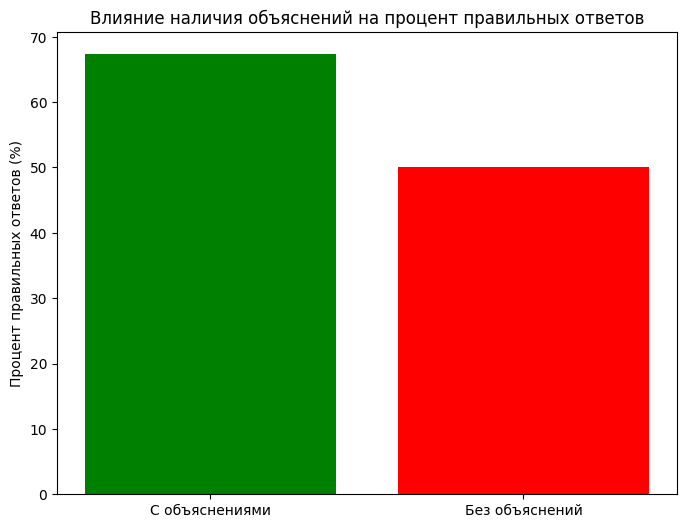

In [18]:
# Наличие объяснений после предыдущих вопросов
explanations = train_questions['prior_question_had_explanation'].copy()
explanations = explanations.fillna(0)  # Заменяем null на 0 (нет объяснений)

# Процент правильных ответов при наличии/отсутствии объяснений
correct_with_expl = train_questions[(train_questions.answered_correctly == 1) & (explanations == 1)].count()
total_with_expl = train_questions[explanations == 1].count()
perc_with_expl = (correct_with_expl / total_with_expl * 100) if total_with_expl > 0 else 0

correct_without_expl = train_questions[(train_questions.answered_correctly == 1) & (explanations == 0)].count()
total_without_expl = train_questions[explanations == 0].count()
perc_without_expl = (correct_without_expl / total_without_expl * 100) if total_without_expl > 0 else 0

# Визуализация
labels = ['С объяснениями', 'Без объяснений']
percentages = [perc_with_expl, perc_without_expl]

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['green', 'red'])
plt.ylabel('Процент правильных ответов (%)')
plt.title('Влияние наличия объяснений на процент правильных ответов')
plt.show()


Вывод:

    Объяснения существенно повышают успех. Студенты, которые видели объяснения, показали значительно более высокие результаты, чем те, кто не получал объяснений. Это указывает на важную роль обратной связи в обучении. Объяснения помогают студентам исправить свои ошибки и лучше понять материал, что повышает их шансы на правильный ответ в будущем.

    Студенты, которые не получают объяснений, менее успешны в ответах на вопросы, что подчеркивает необходимость предоставления разборов ошибок и объяснений как части учебного процесса. Это может быть важным элементом для улучшения образовательного опыта.
    
    Чтобы повысить успеваемость, стоит добавлять объяснения после каждого вопроса или задания. Это поможет студентам лучше понять материал и повысить процент правильных ответов.


Четвертая характеристика это распределение процента правильных ответов по контейнерам заданий:

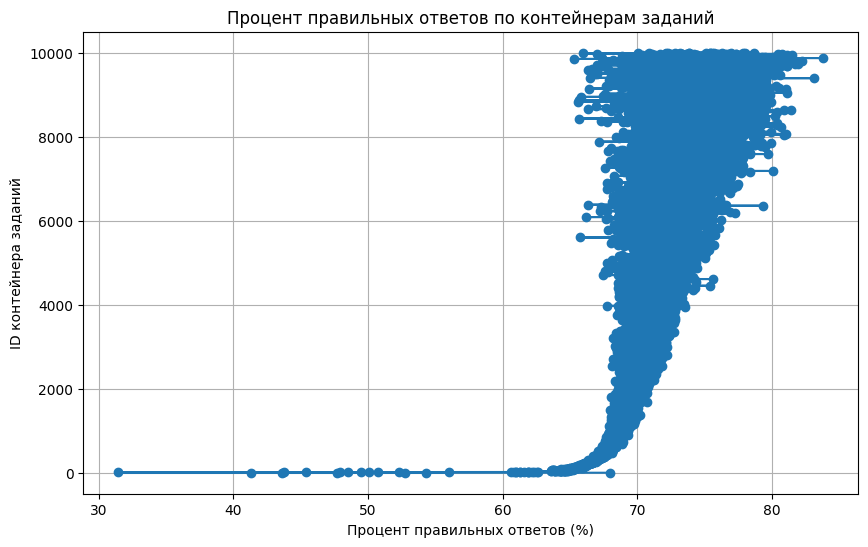

In [19]:
# Анализ по task_container_id - группам вопросов
task_group = train_questions.groupby('task_container_id', agg={
    'correct_count': vaex.agg.sum('answered_correctly'),
    'total_count': vaex.agg.count('answered_correctly')
})

# Процент правильных ответов на каждый task_container_id
task_group['perc_correct'] = (task_group['correct_count'] / task_group['total_count']) * 100

# Визуализация процента правильных ответов по task_container_id
task_group_pd = task_group.to_pandas_df()
plt.figure(figsize=(10, 6))
plt.plot(task_group_pd['perc_correct'], task_group_pd['task_container_id'], marker='o')
plt.ylabel('ID контейнера заданий')
plt.xlabel('Процент правильных ответов (%)')
plt.title('Процент правильных ответов по контейнерам заданий')
plt.grid(True)
plt.show()


    Зоны с низким процентом правильных ответов (ниже 50%): Эти контейнеры могут содержать сложные задания или вопросы, с которыми студенты чаще всего сталкиваются с трудностями. Необходимо изучить эти задания отдельно, чтобы предложить студентам дополнительные ресурсы или пересмотреть их сложность.

    Зоны с высоким процентом правильных ответов (70–80%): Эти контейнеры могут быть хорошо структурированы, и студенты справляются с ними успешно. Возможно, задания в этих контейнерах поддерживают хороший баланс между сложностью и обучающими материалами.

Вывод:

    Анализ конкретных контейнеров: Можно проанализировать контейнеры с низким процентом правильных ответов, чтобы понять, почему студенты сталкиваются с трудностями.
    
    Улучшение материалов: Контейнеры с низким процентом правильных ответов могут быть дополнены объяснениями или пересмотрены для облегчения понимания материала.

Пятая характеристика о распределении повторных ошибок на отдних и тех же вопросах:

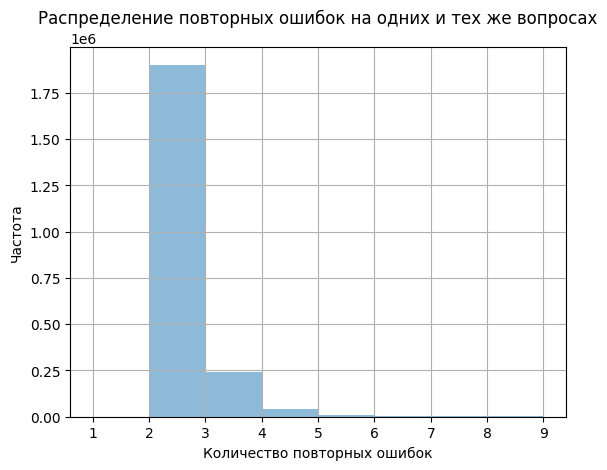

In [20]:
# Считаем количество неправильных ответов на одни и те же вопросы
repeated_mistakes = train_questions[(train_questions.answered_correctly == 0)].groupby(['user_id', 'question_id'], agg={'mistakes': 'count'})

# Выводим пользователей с наибольшим количеством повторных ошибок
repeated_mistakes = repeated_mistakes[repeated_mistakes['mistakes'] > 1]

# Визуализация количества повторных ошибок
plt.hist(repeated_mistakes['mistakes'], bins=range(1, 10), alpha=0.5)
plt.xlabel('Количество повторных ошибок')
plt.ylabel('Частота')
plt.title('Распределение повторных ошибок на одних и тех же вопросах')
plt.grid(True)
plt.show()

    Самая высокая частота ошибок — это 2 повторные ошибки на одном и том же вопросе. Это означает, что студенты чаще всего допускают ошибку на одном вопросе дважды, что может свидетельствовать о сложности вопросов или о недостаточной обратной связи после первой ошибки.

    Число студентов, совершающих 3 ошибки на одном вопросе, значительно ниже, чем для 2 ошибок. С каждым увеличением числа повторных ошибок (4, 5 и более), частота снижается до практически нулевых значений.

Вывод:

    Чем больше раз студент ошибается на одном и том же вопросе, тем больше это указывает на трудности с освоением конкретной темы или навыка, который проверяется этим вопросом.
    
    Малое количество студентов, допустивших более 4 ошибок на одном вопросе, может говорить о том, что большинство студентов в конечном итоге понимают материал или прекращают попытки на этом вопросе.

Шестая характеристика показывает зависимость процента правельных ответов студента и времени суток, когда студент занимался:

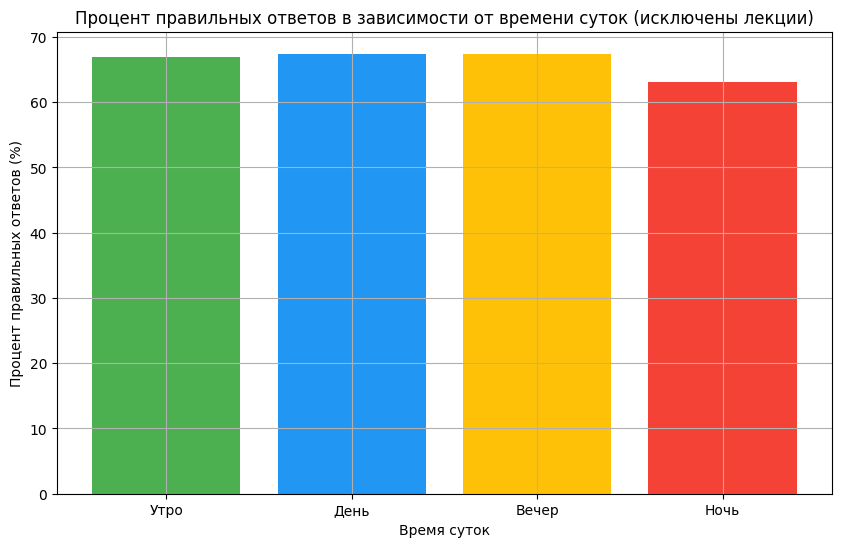

In [21]:
# Фильтрация только тех строк, где данные содержат ответы на вопросы (исключаяя лекции)
filtered_train = train[train['answered_correctly'] != -1]

# Добавление колонки 'hour', преобразование времени в часы
filtered_train['hour'] = (filtered_train['timestamp'] / (1000 * 60 * 60)) % 24

# Добавление виртуальной колонки 'time_of_day' для времени суток (Ночь, Утро, День, Вечер)
filtered_train.add_virtual_column(
    'time_of_day',
    "where((hour >= 0) & (hour < 6), 'Ночь', where((hour >= 6) & (hour < 12), 'Утро', where((hour >= 12) & (hour < 18), 'День', 'Вечер')))"
)

# Группировка по времени суток и анализ успеваемости
time_of_day_stats = filtered_train.groupby('time_of_day', agg={
    'correct_count': vaex.agg.sum('answered_correctly'),
    'total_count': vaex.agg.count('answered_correctly')
})

# Процент правильных ответов для каждого времени суток
time_of_day_stats['perc_correct'] = (time_of_day_stats['correct_count'] / time_of_day_stats['total_count']) * 100

# Преобразование в pandas DataFrame для визуализации
time_of_day_stats_pd = time_of_day_stats.to_pandas_df()

# Визуализация распределения правильных ответов по времени суток
plt.figure(figsize=(10, 6))
plt.bar(time_of_day_stats_pd['time_of_day'], time_of_day_stats_pd['perc_correct'], color=['#4CAF50', '#2196F3', '#FFC107', '#F44336'])
plt.xlabel('Время суток')
plt.ylabel('Процент правильных ответов (%)')
plt.title('Процент правильных ответов в зависимости от времени суток (исключены лекции)')
plt.grid(True)
plt.show()

    Процент правильных ответов довольно стабилен в зависимости от времени суток и находится примерно на уровне 60-65% во всех временных промежутках (утро, день, вечер и ночь). Это говорит о том, что время суток не оказывает значительного влияния на успеваемость студентов при решении вопросов.

    Хотя различия минимальны, можно заметить, что утро и ночь имеют немного меньший процент правильных ответов, чем день и вечер. Это может свидетельствовать о том, что студенты, вероятно, немного менее эффективны в ранние утренние часы или поздно ночью. День и вечер показывают практически одинаковый высокий процент правильных ответов, что может говорить о том, что это оптимальное время для продуктивности.

Вывод:

    Время суток может играть роль в способности студентов концентрироваться. Утро и ночь могут быть менее продуктивными для некоторых людей из-за усталости (вечером) или недосыпа (утром), тогда как день и вечер — это время, когда большинство студентов более активны и бодры.

Заключение: были рассмотрены все главные характеристики успеваемости студентов, которые можно было получить из данной базы данных, можно и дальше искать зависимости, но кардинально чего то нового найти, скорее всего, не получится.